In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import astropy
from   astropy.io import fits as pyfits
import csv
import sys
import os
from   timeit import default_timer as timer
import warnings
import corner

import alderaan.io as io
from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()


# LCIT and SCIT in [days]
lcit = LCIT/60/24
scit = SCIT/3600/24

In [2]:
# select mission, target, and paths
MISSION = "Simulated"
TARGET  = "S00172"

PRIMARY_DIR = '/Users/research/projects/alderaan/'
CSV_FILE = PRIMARY_DIR + "Catalogs/injection_and_recovery_results-sim-2-50-v2-fixedLD.csv"

# Make sure the necessary paths exist

In [3]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)

if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)

# Read in posterior results catalog

In [4]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    KOI_ID = TARGET
    
elif MISSION == 'Simulated':
    KOI_ID = "K" + TARGET[1:]

else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")
    
    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID
NPL = np.sum(use)

RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
MSTAR = np.array(target_dict['mstar'], dtype='float')[use]

U1 = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2 = np.array(target_dict['limbdark_2'], dtype='float')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
RADII   = np.array(target_dict['prade'], dtype='float')[use]
IMPACTS = np.array(target_dict['impact'], dtype='float')[use]

Reading in data from csv file


In [5]:
# do some consistency checks
if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [6]:
# sort planet parameters by period
order = np.argsort(PERIODS)

PERIODS = PERIODS[order]
EPOCHS  = EPOCHS[order]
RADII   = RADII[order]
IMPACTS = IMPACTS[order]

# Read in detrended lightcurves and initial transit time estimates
#### The data can be generated by running the script "detrend_and_estimate_noise.py"

In [7]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

In [8]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
EPOCHS  = np.zeros(NPL)
PERIODS = np.zeros(NPL)

transit_inds = []
indep_transit_times = []
indep_ephemeris = []


for npl in range(NPL):
    # read in predetermined transit times
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    indep_transit_times.append(data_in[:,1])
    
    # do a quick fit to get a linear ephemeris
    pfit = np.polyfit(transit_inds[npl], indep_transit_times[npl], 1)
    
    indep_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    EPOCHS[npl] = pfit[1]
    PERIODS[npl] = pfit[0]
    
    
# make sure transit_inds are zero-indexed
for npl in range(NPL):
    transit_inds[npl] = np.array(transit_inds[npl] - transit_inds[npl][0], dtype="int")
    
    
fixed_ephemeris = np.copy(indep_ephemeris)
fixed_transit_times = np.copy(indep_transit_times)

# Set time baseline

In [9]:
# determine the time baseline
time_min = []
time_max = []

try:
    time_min.append(sc.time.min())
    time_max.append(sc.time.max()) 
except:
    pass


try:
    time_min.append(lc.time.min())
    time_max.append(lc.time.max())     
except:
    pass
    
    
TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [10]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.radius   = RADII[npl]
    p.impact   = IMPACTS[npl]
            
    # transit times and indexes
    p.tts = fixed_transit_times[npl]
    p.index = transit_inds[npl]
    
    
    # calculate semimajor axis and transit duration
    p.sma = get_sma(p.period, MSTAR)
    p.duration = get_dur_tot(p.period, p.radius/RSRE, RSTAR, p.impact, p.sma)
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 2 Planet objects


# Flag high-quality transits

In [11]:
for npl, p in enumerate(planets):
    count_expect_lc = int(np.ceil(p.duration/lcit))
    count_expect_sc = int(np.ceil(p.duration/scit))
        
    quality = []
    
    # cut out the stamps:
    for i, t0 in enumerate(p.tts):
        
        try:
            in_sc = np.abs(sc.time - t0)/p.duration < 0.5
            in_lc = np.abs(lc.time - t0)/p.duration < 0.5
            
            near_sc = np.abs(sc.time - t0)/p.duration < 1.5
            near_lc = np.abs(lc.time - t0)/p.duration < 1.5
            
            qual_in = (np.sum(in_sc) > 0.5*count_expect_sc) + (np.sum(in_lc) > 0.5*count_expect_lc)
            qual_near = (np.sum(near_sc) > 1.5*count_expect_sc) + (np.sum(near_lc) > 1.5*count_expect_lc)
            
            quality.append(qual_in*qual_near)
                                    
                        
        except:
            in_lc = np.abs(lc.time - t0)/p.duration < 0.5
            near_lc = np.abs(lc.time - t0)/p.duration < 1.5
            
            qual_in = (np.sum(in_lc) > 0.5*count_expect_lc)
            qual_near = (np.sum(near_lc) > 1.5*count_expect_lc)
            
            quality.append(qual_in*qual_near)
            
    p.quality = np.copy(quality)

# Flag where transits overlap

In [12]:
# identify overlapping transits
durs = np.zeros(NPL)
for npl, p in enumerate(planets):
    durs[npl] = p.duration


overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj)/durs.max() < 1.5
                
    planets[i].overlap = np.copy(overlap[i])

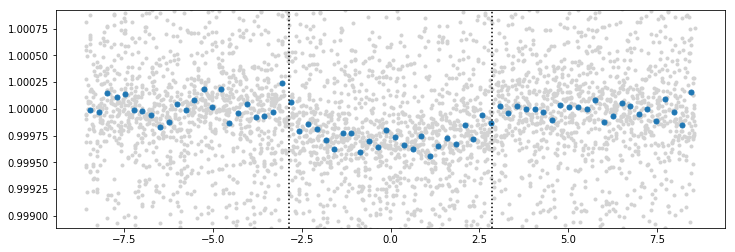

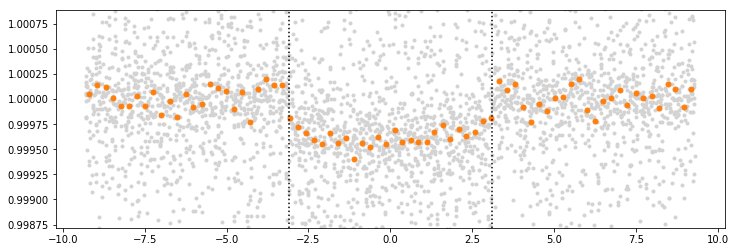

In [13]:
for npl, p in enumerate(planets):
    tts = p.tts[p.quality*~p.overlap]
    
    
    if len(tts) == 0:
        print("No non-overlapping high quality transits found for planet {0} (P = {1} d)".format(npl, p.period))
    
    
    else:
        t_ = []
        f_ = []


        for t0 in tts:
            try:
                neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            except:
                neartransit_sc = None

            try:
                neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
            except:
                neartransit_lc = None

            if (neartransit_lc is not None) and (np.sum(neartransit_lc) > 0):
                t_.append(lc.time[neartransit_lc] - t0)
                f_.append(lc.flux[neartransit_lc])

            if (neartransit_sc is not None) and (np.sum(neartransit_sc) > 0):
                undersample = 6
                t_.append(sc.time[neartransit_sc][::undersample] - t0)
                f_.append(sc.flux[neartransit_sc][::undersample])


        t_ = np.hstack(t_)
        f_ = np.hstack(f_)

        order = np.argsort(t_)
        t_ = t_[order]
        f_ = f_[order]

        f_bin = bin_data(t_, f_, LCIT/60/24/2)
        t_bin = bin_data(t_, t_, LCIT/60/24/2)

        plt.figure(figsize=(12,4))
        plt.plot(t_*24, f_, ".", c="lightgrey")
        plt.plot(t_bin*24, f_bin, "o", ms=5, color="C{0}".format(npl))
        plt.axvline(-24*p.duration/2, color="k", ls=":")
        plt.axvline( 24*p.duration/2, color="k", ls=":")
        plt.ylim(f_bin.min()-np.std(f_), f_bin.max()+np.std(f_))
        plt.show()